In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import warnings
import torch
from sklearn.cluster import KMeans

import sys
sys.path.insert(0, str(Path("__file__").parent))
from bbox_tools import letter_resize_bbox
from image_tools import letter_resize_img

In [11]:
import numpy as np
from pycocotools.coco import COCO
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from abc import ABC
from pathlib import Path
from pycocotools.coco import COCO


class COCOGenerator(ABC):

    def __init__(self, data_dir, setname, use_crowd):
        self.setname = setname
        self.data_dir = Path(data_dir)
        self.use_crowd = use_crowd
        self.annpath = self.data_dir / 'annotations' / f'instances_{setname}.json'
        self.coco = COCO(self.annpath)
        self.img_ids = self.coco.getImgIds()
        self.classes, self.class2id, self.id2class, self.class2label, self.label2class = [], {}, {}, {}, {}
        self.get_coco_info()
        self.num_class = len(self.classes)
        super(COCOGenerator, self).__init__()

    def get_coco_info(self):
        """
        pass
        """
        category_info = self.coco.loadCats(ids=self.coco.getCatIds())
        category_info.sort(key=lambda x: int(x['id']))
        for category in category_info:
            # self.classes.append(category['id'])
            self.class2id[len(self.classes)] = category['id']
            self.id2class[category['id']] = len(self.classes)
            self.class2label[len(self.classes)] = category['name']
            self.label2class[category['name']] = len(self.classes)
            self.classes.append(category['id'])

    def __len__(self):
        return len(self.img_ids)

    def size(self):
        """
        Size of COCO dataset.
        :return:
        """
        return len(self.img_ids)

    def has_label(self, label):
        return label in self.class2label

    def has_name(self, name):
        return name in self.label2class

    def label_to_name(self, label):
        return self.class2label[label]

    def name_to_label(self, name):
        return self.label2class[name]

    def coco_id_to_class(self, coco_id):
        return self.id2class[coco_id]

    def coco_id_to_label(self, coco_id):
        return self.class2label[self.coco_id_to_class(coco_id)]

    def get_img_path(self, idx):
        return str(self.data_dir / self.setname / f'{self.img_ids[idx]:>012}.jpg')

    def load_annotations(self, idx):
        """

        :param idx:
        :return: return box formate -> [xmin, ymin, xmax, ymax]
        """
        ann_ids = self.coco.getAnnIds(imgIds=self.img_ids[idx], iscrowd=self.use_crowd)
        img_info = self.coco.imgs[self.img_ids[idx]]
        annotations = {'classes': np.empty((0,), dtype=np.uint16), 'bboxes': np.empty((0, 4), dtype=np.float32)}
        # 有些img没有annotations
        if len(ann_ids) == 0:
            return annotations
        else:
            # anns is a list
            anns = self.coco.loadAnns(ids=ann_ids)
            for idx, ann in enumerate(anns):
                # 有些annotations中bbox的width/height值小于1，遇到这样的bbox就舍弃掉
                if (ann['bbox'][2]) < 1 or (ann['bbox'][3] < 1):
                    continue
                else:
                    annotations['classes'] = np.concatenate([annotations['classes'],
                                                             [self.coco_id_to_class(ann['category_id'])]],
                                                            axis=0)
                    annotations['bboxes'] = np.concatenate([annotations['bboxes'],
                                                            [[ann['bbox'][0],
                                                              ann['bbox'][1],
                                                              ann['bbox'][0] + ann['bbox'][2],
                                                              ann['bbox'][1] + ann['bbox'][3]]]],
                                                           axis=0)
        return annotations

### get the whole bbox in the dataset

In [18]:

from visualizer import plt_plot_img

if __name__ == "__main__":
    dataset_dir = Path('/Volumes/Samsung/Dataset/COCO')
    dst_size = [448, 448]
    coco = COCOGenerator(dataset_dir, "train2017", False)
    all_bboxes = np.empty((0, 4))
    for i in tqdm(range(len(coco)), total=len(coco)):
        ann = coco.load_annotations(i)
        img_id = coco.img_ids[i]
        box = ann['bboxes']
        cls_ = ann['classes']
        img_src = coco.get_img_path(i)
        assert Path(img_src).exists()
        img_arr = cv2.imread(str(img_src))[..., ::-1]
        img_arr, info = letter_resize_img(img_arr, dst_size)
        box = letter_resize_bbox(box, info)
        # plt_plot_img(img_arr, box, [str(i) for i in cls_], [1 for i in cls_])
        all_bboxes = np.concatenate([all_bboxes, box], axis=0)
        # break

loading annotations into memory...
Done (t=14.37s)
creating index...
index created!


100%|██████████| 118287/118287 [29:41<00:00, 66.42it/s]


### show distribution

In [19]:
print(all_bboxes.shape)

(849902, 4)


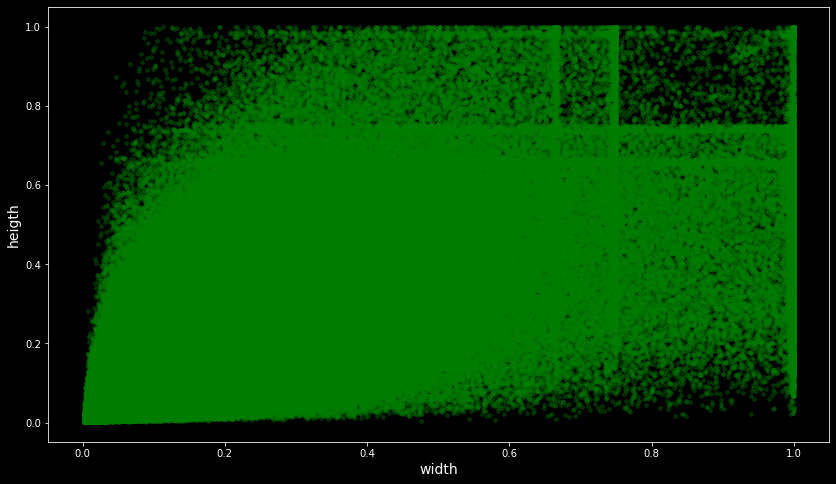

In [20]:
norm_ws, norm_hs = [], []
for i in range(len(all_bboxes)):
    norm_ws.append((all_bboxes[i][2] - all_bboxes[i][0]) / dst_size[0])
    norm_hs.append((all_bboxes[i][3] - all_bboxes[i][1]) / dst_size[1])


fig = plt.figure(figsize=[14, 8])
ax = fig.add_subplot(111)
ax.scatter(x=norm_ws, y=norm_hs, s=14, alpha = 0.3, c='g')
ax.set_xlabel('width', fontsize=14)
ax.set_ylabel('heigth', fontsize=14)
plt.show()

## Kmeans anchors

### iou

In [25]:

def iou(center_box, other_boxes):
    intersection_box = np.where(center_box < other_boxes, center_box, other_boxes)
    intersection_area = np.prod(intersection_box, axis=1)
    center_box_area = np.prod(center_box)
    otherbox_areas = np.prod(other_boxes, axis=1)
    ious = intersection_area / (center_box_area + otherbox_areas - intersection_area)
    return ious

### alias sample

In [26]:
def alias_setup(probs):
    """
    probs： 某个概率分布
    返回: Alias数组与Prob数组
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)
    smaller = []
    larger = []
    for i, prob in enumerate(probs):
        q[i] = K * prob  # 概率
        if q[i] < 1.0:
            smaller.append(i)
        else:
            larger.append(i)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


def alias_draw(J, q):
    '''
    输入: Prob数组和Alias数组
    输出: 一次采样结果
    '''
    K = len(J)
    k = int(np.floor(np.random.rand() * K))  # 随机取一列
    if np.random.rand() < q[k]:
        return k
    else:
        return J[k]

def alias_sample(probs, samples):
    assert isinstance(samples, int), 'Samples must be a integer.'
    sample_result = []
    J, p = alias_setup(probs)
    for i in range(samples):
        sample_result.append(alias_draw(J, p))
    return sample_result

### kmeans

In [34]:
def classification(k, bboxes, use_alias):
    length = len(bboxes)
    center_index = get_centers(k, bboxes, use_alias)
    center_coord = bboxes[center_index]
    center_tmp = np.zeros_like(center_coord)
    ori_dis = np.full(shape=length, fill_value=np.inf)
    class_list = np.zeros(shape=length) - 1
    
    times = 1
    while np.sum(np.square(center_coord - center_tmp)) > 1e-7:
        times += 1
        center_tmp = center_coord.copy()
        for i in range(k):
            new_dis = 1 - iou(center_coord[i], bboxes)
            class_list = np.where(ori_dis < new_dis, class_list, i)
            ori_dis = np.where(ori_dis < new_dis, ori_dis, new_dis)
        # update center
        for i in range(k):
            center_coord[i] = np.mean(bboxes[class_list == i], axis=0)
        
    return class_list, center_coord


def show_result(class_list, raw_data, center_coordinate):
    print('Showing... ...')
    colors = [
              '#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#228B22',
              '#0000FF', '#FF1493', '#EE82EE', '#000000', '#FFA500',
              '#00FF00', '#006400', '#00FFFF', '#0000FF', '#FFFACD',
              ]

    use_color = []
    for node in class_list:
        use_color.append(colors[int(node)])
        
    plt.figure(num=1, figsize=(16, 9))
    plt.scatter(x=raw_data[:, 0], y=raw_data[:, 1], c=use_color, s=50, marker='o', alpha=0.3)
    plt.scatter(x=center_coordinate[:, 0], y=center_coordinate[:, 1], c='b', s=200, marker='+', alpha=0.8)
    plt.show()

def get_centers(k, bboxes, use_alias):
    if use_alias:
        centers = [random.randint(a=0, b=len(bboxes))]
        tmp_dis = np.full(shape=len(bboxes), fill_value=np.inf)
        while len(centers) < k:
            for i, center in enumerate(centers):
                dis = 1 - iou(center, bboxes)
                dis = np.where(dis < tmp_dis, dis, tmp_dis)
            probs = dis / np.sum(dis)
            centers.append(np.random.choice(a=len(bboxes), size=1, p=probs)[0])
            # centers.append(alias_sample(probs, 1)[0])
        return centers
    else:
        return np.random.choice(a=np.arange(len(bboxes)), size=k)
        

def kmeans(raw_data, k, use_alias=False, show=True):
    class_list, center_coordinate = classification(k, raw_data, use_alias)
    if show:
        show_result(class_list, raw_data, center_coordinate)
    return class_list, center_coordinate

Showing... ...


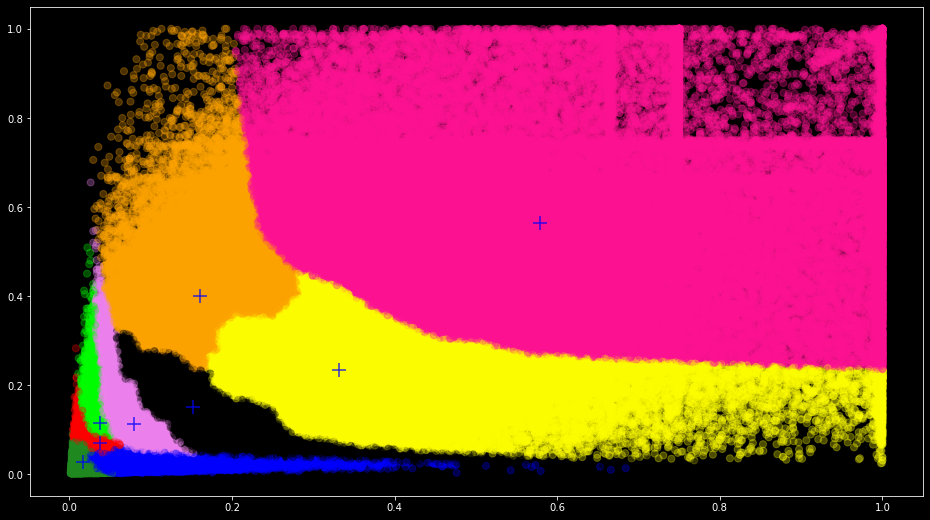

anchors: 
[[ 16.70995805  31.61532094]
 [ 72.03375931 179.6015074 ]
 [148.3863083  104.66502857]
 [ 16.84020721  51.52128295]
 [  7.31329267  12.54722664]
 [ 27.22001992  15.30502812]
 [259.29519609 253.18382375]
 [ 35.76997811  50.22651854]
 [ 67.82456538  67.85292618]]


In [43]:
norm_whs = np.concatenate((np.array(norm_ws)[:, None], np.array(norm_hs)[:, None]), axis=1)
_, centers = kmeans(norm_whs, 9)
print(f"anchors: \n{centers * dst_size}")

### kmeans++

Showing... ...


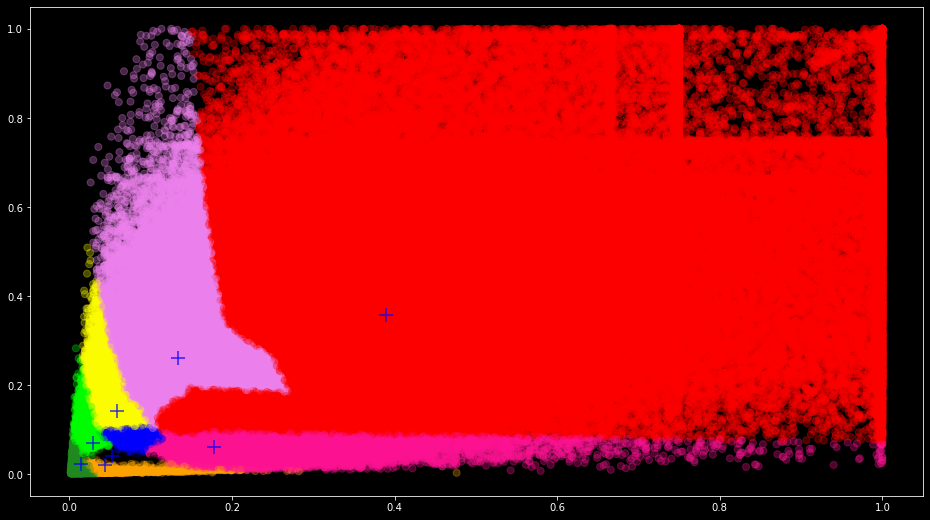

anchors: 
[[174.41610025 160.02054161]
 [ 19.68927482   9.784654  ]
 [ 25.97416932  63.50833815]
 [ 12.79809873  31.15719601]
 [  6.20255881  10.11119147]
 [ 32.23579376  34.67368285]
 [ 79.48912285  27.72845925]
 [ 59.99089599 116.90631531]
 [ 23.67291142  17.98326768]]


In [44]:
_, centers = kmeans(norm_whs, 9, use_alias=True)
print(f"anchors: \n{centers * dst_size}")